In [1]:
from ThesisPackage.Environments.collectors.collectors_env import Collectors
from ThesisPackage.RL.Decentralized_PPO.util import flatten_list, reverse_flatten_list_with_agent_list
import torch
import numpy as np
import time
from ThesisPackage.RL.Centralized_PPO.multi_ppo import PPO_Multi_Agent_Centralized

In [2]:
def make_env():
    sequence_length = 2
    vocab_size = 3
    max_episode_steps = 2048
    env = Collectors(width=20, height=20, vocab_size=vocab_size, sequence_length=sequence_length, max_timesteps=max_episode_steps, timestep_countdown=13)
    # env = ParallelFrameStack(env, 4)
    return env

In [3]:
def load():
    env = make_env()
    agent = PPO_Multi_Agent_Centralized(env, device="cpu")
    state_dict = torch.load("/Users/cowolff/Documents/GitHub/ma.pong_rl/models/soccer_2vs2_randomized.pt")
    agent.agent.load_state_dict(state_dict)
    return agent

In [4]:
num_steps = 10000
agent = load()
env = make_env()

/Users/cowolff/miniconda3/envs/thesis/lib/python3.10/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


In [5]:
obs, info = env.reset()
action = {}

obs = [obs]
print(obs)
obs = np.array(flatten_list(obs))
obs = torch.tensor(obs, dtype=torch.float32, requires_grad=True)

action = agent.agent.actor(obs)

action.backward(torch.ones_like(action))

saliency = obs.grad.data.abs()

saliency = saliency.numpy()

[{'player_1': array([ 7.7352314,  7.1146545,  0.       ,  1.       , -1.081718 ,
        0.6756439, 13.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ],
      dtype=float32), 'player_2': array([ 7.7352314,  7.1146545,  0.       ,  1.       , -1.081718 ,
        0.6756439, 13.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ],
      dtype=float32)}]


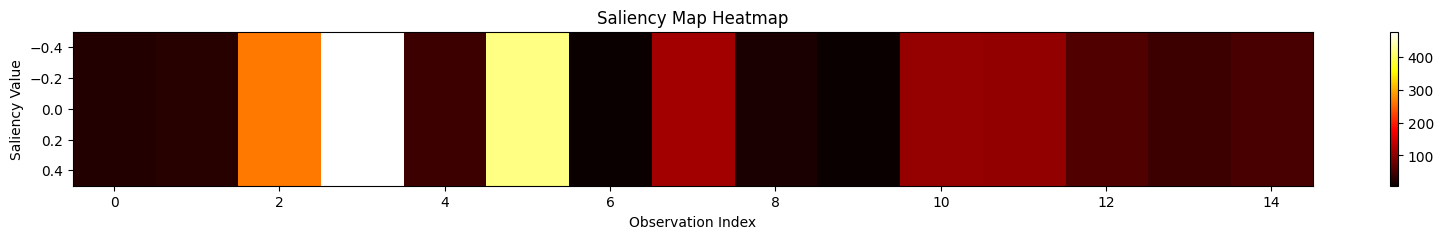

In [6]:
import matplotlib.pyplot as plt

# Reshape the 1D saliency map to a 2D array (1 row x N columns)
saliency_map_2d = saliency[0].reshape(1, -1)

# Plot the saliency map as a 2D heatmap
plt.figure(figsize=(20, 2))  # Adjust figure size to make it more readable
plt.imshow(saliency_map_2d, cmap='hot', aspect='auto', interpolation='nearest')
plt.colorbar()
plt.title('Saliency Map Heatmap')
plt.xlabel('Observation Index')
plt.ylabel('Saliency Value')
plt.show()


In [12]:
# split the observation in 4 equal parts
unstacked_saliencies = np.stack(saliency, axis=0)
print(np.average(unstacked_saliencies[:, -1 * env.sequence_length:]))

47.229847


In [28]:
import matplotlib.lines as mlines

def plot_saliencies(full_saliencies, path=None, title="Heatmap for one epoch"):
    # Transposing the reshaped data for desired orientation#
    data_reshaped = full_saliencies.reshape(-1, full_saliencies.shape[2])
    data_transposed = data_reshaped.T

    # Plotting the heatmap with the new orientation
    plt.figure(figsize=(25, 5))
    plt.imshow(data_transposed, aspect='auto', cmap='viridis')
    plt.colorbar(label='Values')
    plt.title(title)
    plt.xlabel('Timestep')
    plt.ylabel('Features')

    red_line = mlines.Line2D([], [], color='red', label='Language Channel')

    # Adding a red box around the last two features (4 and 5)
    # rect = plt.Rectangle((-0.1, 9.5), data_reshaped.shape[0] - 0.9, 1.99, linewidth=2, edgecolor='red', facecolor='none')
    # plt.gca().add_patch(rect)

    plt.legend(handles=[red_line])

    if path != None:
        plt.savefig(path)
    else:
        plt.show()


def plot_language_saliencies(full_saliences, path=None):
    plt.figure(figsize=(20, 5))  # Adjust figure size to make it more readable

    plot_saliences = full_saliences.reshape(full_saliences.shape[0], -1)

    plt.plot(plot_saliences[:, -1], label='Channel 2')
    plt.plot(plot_saliences[:, -2], label="Channel 1")
    # plt.plot(saliencies)
    plt.title('Saliency of language channel')
    plt.xlabel('Timestep')
    plt.ylabel('Saliency Sum')
    plt.legend()
    if path != None:
        plt.savefig(path)
    else:
        plt.show()

In [14]:
def integrated_gradients(inputs, model, target_label_idx, baseline=None, steps=100):
    if baseline is None:
        baseline = torch.zeros_like(inputs)
    assert baseline.shape == inputs.shape
    
    grads = []

    for i in range(num_steps):
        scaled_input = torch.tensor(baseline + (float(i) / steps) * (inputs - baseline), requires_grad=True)
        # scaled_input.requires_grad = True
        logits = model(scaled_input)
        loss = logits[0, target_label_idx]
        loss.backward()
        grads.append(scaled_input.grad.data.cpu().numpy())

    avg_grads = np.average(grads[:-1], axis=0)
    integrated_grad = (inputs.detach().cpu().numpy() - baseline.cpu().numpy()) * avg_grads

    return integrated_grad

In [22]:
def get_means(env, model, epochs):
    means = []
    tokens = {channel: {0: 0, 1: 1, 2: 2} for channel in [1, 2]}
    for i in range(epochs):
        obs, info = env.reset()
        state = env.state()
        while True:
            obs = [obs]
            state = [state]
            obs = np.array(flatten_list(obs))
            state = np.array(flatten_list(state))
            means.append(obs)
            obs = torch.tensor(obs, dtype=torch.float32)
            state = torch.tensor(state, dtype=torch.float32)
            with torch.no_grad():
                action, _, _, _ = model.agent.get_action_and_value(obs, state)
                action = reverse_flatten_list_with_agent_list(action, agent.agents)[0]
            
            action = {agent: cur_action.numpy() for agent, cur_action in action.items()}
            obs, rewards, terminations, truncations, info = env.step(action)
            state = env.state()
            for channel in [1, 2]:
                for paddle in env.agents:
                    cur_token = int(obs[paddle][-1 * channel])
                    tokens[channel][cur_token] += 1
            if any([truncations[agent] or terminations[agent] for agent in env.agents]):
                break
    means = np.stack(means)
    return means, tokens

means, tokens = get_means(env, agent, 100)
means = means.reshape(-1, means.shape[-1])
means = np.mean(means, axis=0)
print(means, tokens)

[-8.2674801e-01 -2.9041576e-01  2.2896206e-01  5.2020425e-01
  2.6518279e-01  3.7218377e-02  5.9369884e+00  1.0135408e-01
  1.6259546e-03  1.5058739e+00 -1.5039599e-03  2.2407290e-02
  1.3136348e-01  9.7721606e-01  9.6653610e-01] {1: {0: 1893, 1: 1820, 2: 1908}, 2: {0: 1818, 1: 1907, 2: 1896}}


In [25]:
def test_integrated_gradients(smaller = True , threshold = 0.5, noise=False, epochs=1, tracking_agent="player_1"):
    saliencies = []
    full_saliences = []
    obs, info = env.reset()
    average_length = []
    average_noise_share = []
    tokens = []
    for i in range(epochs):
        print(f"Epoch {i} out of {epochs}")
        timestep = 0
        noises = []
        while True:
            timestep += 1
            traking_index = env.agents.index(tracking_agent)
            tokens.append(obs[tracking_agent][-1 * env.sequence_length:])
            obs = [obs]
            state = [env.state()]

            obs = np.array(flatten_list(obs))
            state = np.array(flatten_list(state))

            obs_track = torch.tensor(np.expand_dims(obs[traking_index], axis=0), dtype=torch.float32, requires_grad=True)
            
            baselines = torch.tensor(np.expand_dims(means, axis=0), dtype=torch.float32)
            baselines[0] = 9.0
            integrated_grads = integrated_gradients(obs_track, agent.agent.actor, 0, baseline=baselines, steps=20)

            integrated_grads = (integrated_grads - integrated_grads.min()) / (integrated_grads.max() - integrated_grads.min())
            language_saliences = np.sum(integrated_grads[0, -1 * env.sequence_length:])

            if smaller and noise:
                if integrated_grads[0][-1] < threshold:
                    obs[:, -1] = np.random.randint(0, 2)
                    noises.append(1)
                else:
                    noises.append(0)
            elif not smaller and noise:
                if integrated_grads[0][-1] > threshold:
                    obs[:, -1] = np.random.randint(0, 2)
                    noises.append(1)
                else:
                    noises.append(0)

            obs = torch.tensor(obs, dtype=torch.float32)
            state = torch.tensor(state, dtype=torch.float32)
            with torch.no_grad():
                actions, _, _, _ = agent.agent.get_action_and_value(obs, state)
                actions = reverse_flatten_list_with_agent_list(actions, agent.agents)

            actions = actions[0]
            actions = {agent: action.cpu().numpy() for agent, action in actions.items()}

            saliencies.append(language_saliences)
            full_saliences.append(integrated_grads)

            obs, _, truncations, terminations, infos = env.step(actions)

            if any([truncations[agent] or terminations[agent] for agent in env.agents]):
                average_length.append(timestep)
                obs, info = env.reset()
                state = env.state()
                break
        average_noise_share.append(np.mean(noises))
    full_saliences = np.stack(full_saliences, axis=0)
    return saliencies, average_length, full_saliences, np.mean(average_noise_share), np.array(tokens)

In [38]:
saliencies, average_length, full_saliences, _, tokens = test_integrated_gradients(epochs=1)
print(average_length)

Epoch 0 out of 1


/var/folders/sv/xzgywwf17_d3f25rzb7z7jjh0000gn/T/ipykernel_34735/93629171.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  scaled_input = torch.tensor(baseline + (float(i) / steps) * (inputs - baseline), requires_grad=True)


[48]


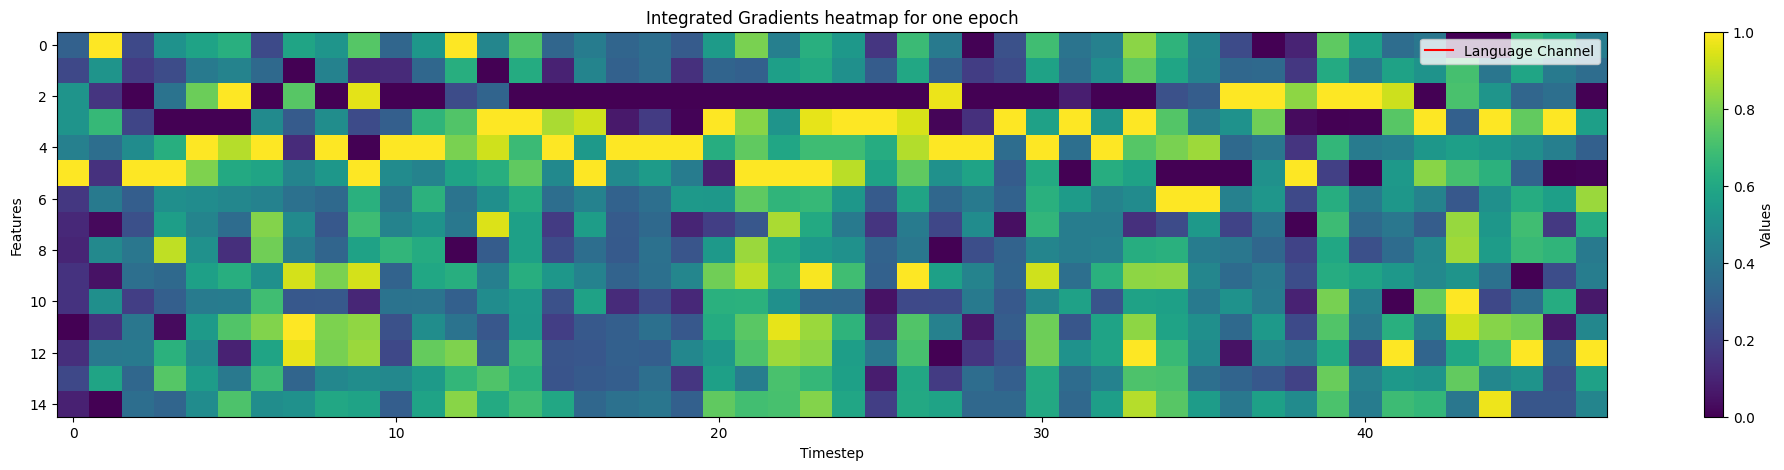

In [39]:
plot_saliencies(full_saliences, title="Integrated Gradients heatmap for one epoch")

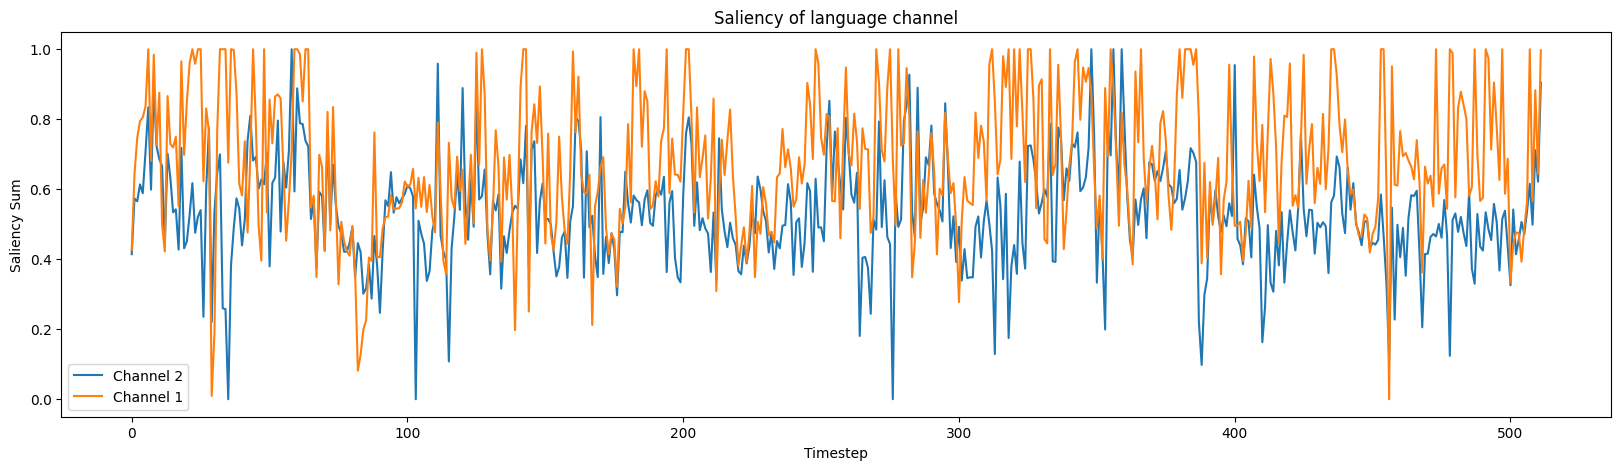

In [26]:
plot_language_saliencies(full_saliences)

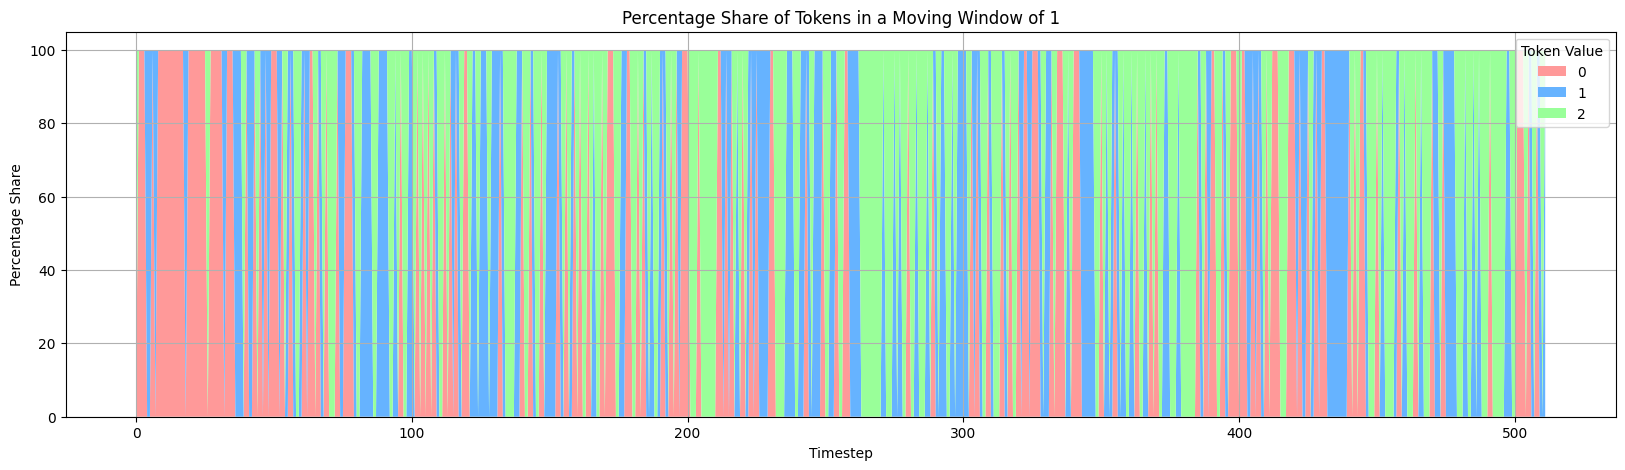

In [28]:
from collections import Counter

# Flatten the array
flattened_array = tokens[:,0]

# Step 3: Compute frequencies over a moving window of 20
window_size = 1
percentages = []

for i in range(len(flattened_array) - window_size + 1):
    window = flattened_array[i:i + window_size]
    counter = Counter(window)
    total_count = sum(counter.values())
    percentage = {k: (v / total_count) * 100 for k, v in counter.items()}
    percentages.append(percentage)

# Prepare data for plotting
x = list(range(len(percentages)))
perc_0 = [freq.get(0.0, 0) for freq in percentages]
perc_1 = [freq.get(1.0, 0) for freq in percentages]
perc_2 = [freq.get(2.0, 0) for freq in percentages]

# Step 4: Plot the results as a stacked area plot
plt.figure(figsize=(20, 5))
plt.stackplot(x, perc_0, perc_1, perc_2, labels=['0', '1', '2'], colors=['#ff9999','#66b3ff','#99ff99'])
plt.xlabel('Timestep')
plt.ylabel('Percentage Share')
plt.title(f'Percentage Share of Tokens in a Moving Window of {window_size}')
plt.legend(loc='upper right', title='Token Value')
plt.grid(True)
plt.show()

In [35]:
def test(smaller = True , threshold = 0.5, noise=False, epochs=100, tracking_agent="paddle_1"):
    saliencies = []
    full_saliences = []
    obs, info = env.reset()
    average_length = []
    average_noise_share = []
    tokens = []
    for i in range(epochs):
        timestep = 0
        noises = []
        while True:
            timestep += 1
            traking_index = env.agents.index(tracking_agent)
            tokens.append(obs[tracking_agent][-1 * env.sequence_length:])
            obs = [obs]
            obs = np.array(flatten_list(obs))

            obs_track = torch.tensor(np.expand_dims(obs[traking_index], axis=0), dtype=torch.float32, requires_grad=True)
            logits = agent.agent.actor(obs_track)

            grad_tensor = torch.zeros_like(logits)
            grad_tensor[:, :-6] = 1

            logits.backward(grad_tensor)

            saliency = obs_track.grad.data.abs()

            saliency = saliency.numpy()
            saliency = (saliency - saliency.min()) / (saliency.max() - saliency.min())

            average_language = np.sum(saliency[:, -1 * env.sequence_length:])

            if smaller:
                if average_language < threshold and noise:
                    for agent_name in env.agents:
                        obs[:, -1 * env.sequence_length:] = np.random.randint(0, 2, size=(env.sequence_length,))
                    noises.append(1)
                else:
                    noises.append(0)
            elif not smaller:
                if average_language > threshold and noise:
                    for agent_name in env.agents:
                        obs[:, -1 * env.sequence_length:] = np.random.randint(0, 2, size=(env.sequence_length,))
                    noises.append(1)
                else:
                    noises.append(0)

            obs = torch.tensor(obs, dtype=torch.float32)
            with torch.no_grad():
                actions, _, _, _ = agent.agent.get_action_and_value(obs)
                actions = reverse_flatten_list_with_agent_list(actions, agent.agents)

            actions = actions[0]
            actions = {agent: action.cpu().numpy() for agent, action in actions.items()}

            saliencies.append(average_language)
            full_saliences.append(saliency)

            obs, _, truncations, terminations, infos = env.step(actions)

            if any([truncations[agent] or terminations[agent] for agent in env.agents]):
                average_length.append(timestep)
                obs, info = env.reset()
                break
        average_noise_share.append(np.mean(noises))
    full_saliences = np.stack(full_saliences, axis=0)
    return saliencies, average_length, full_saliences, np.mean(average_noise_share), np.array(tokens)

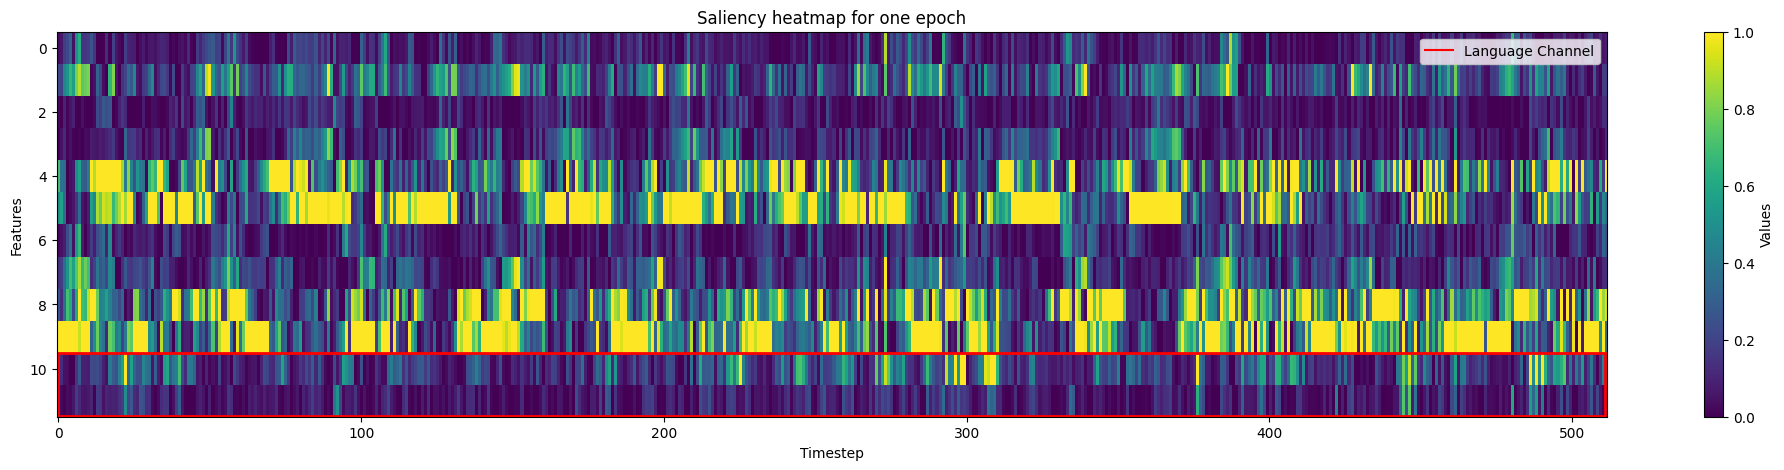

In [36]:
saliencies, average_length, full_saliences, _, tokens = test(epochs=1)
plot_saliencies(full_saliences)

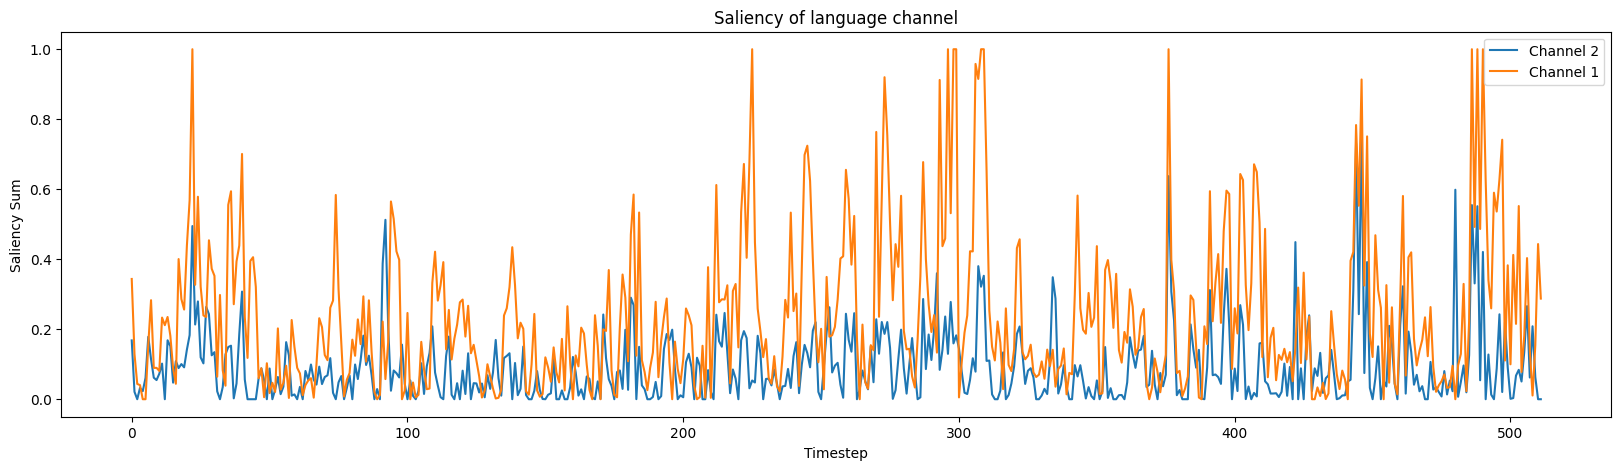

In [38]:
plot_language_saliencies(full_saliences, path="/Users/cowolff/Documents/GitHub/ma.pong_rl/Plotting/Saliency/saliencies_live.pdf")

In [17]:
results = {}
_, average_length, _, _, _ = test()
results["no_noise"] = np.mean(average_length)

_, average_length, _, average_noise_small, _ = test(noise=True, threshold=0.2)
results["smaller noise"] = np.mean(average_length)

_, average_length, _, average_noise_big, _ = test(smaller=False, threshold=0.2, noise=True)
results["bigger noise"] = np.mean(average_length)

print(results, average_noise_small, average_noise_big)

{'no_noise': 406.43, 'smaller noise': 341.34, 'bigger noise': 319.68} 0.4314093804019666 0.5831580105653658


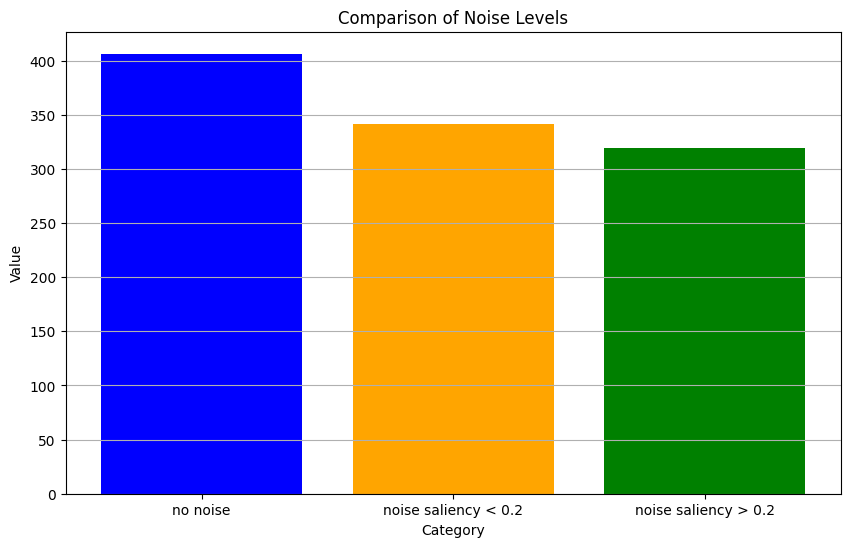

In [18]:
# Extract keys and values
categories = ['no noise', 'noise saliency < 0.2', 'noise saliency > 0.2']
values = list(results.values())

# Create the plot
plt.figure(figsize=(10, 6))
plt.bar(categories, values, color=['blue', 'orange', 'green'])
plt.xlabel('Category')
plt.ylabel('Value')
plt.title('Comparison of Noise Levels')
plt.grid(axis='y')

# Show the plot
plt.show()

In [19]:
saliencies, average_length, full_saliences, _, tokens = test(epochs=1)

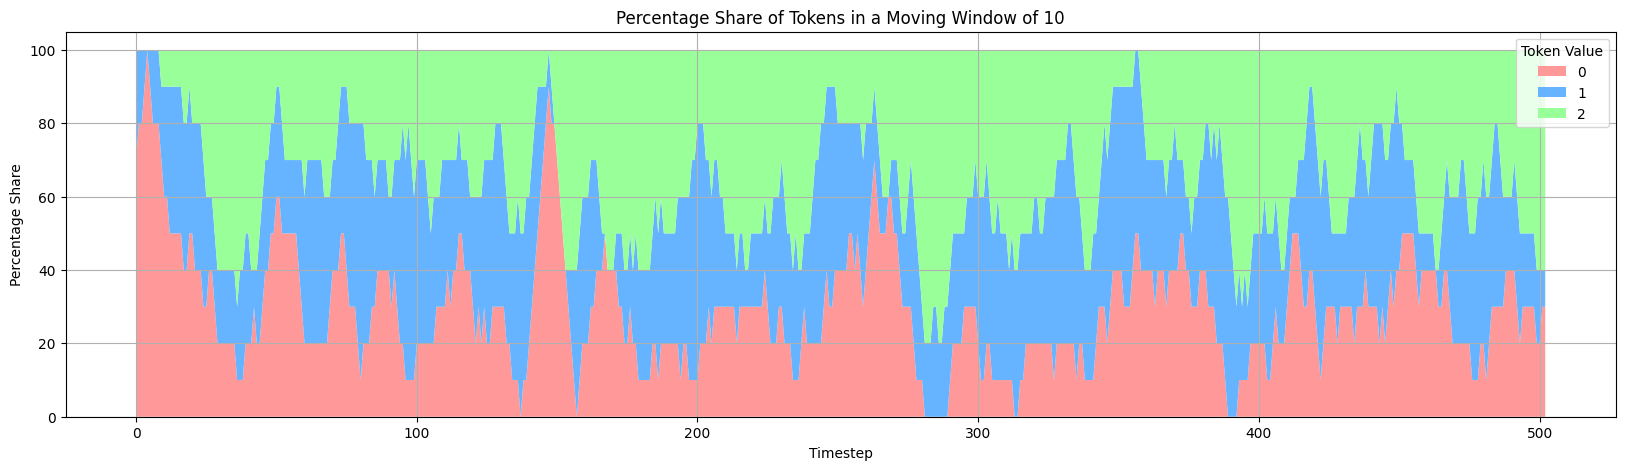

In [20]:
from collections import Counter

# Flatten the array
flattened_array = tokens[:,0]

# Step 3: Compute frequencies over a moving window of 20
window_size = 10
percentages = []

for i in range(len(flattened_array) - window_size + 1):
    window = flattened_array[i:i + window_size]
    counter = Counter(window)
    total_count = sum(counter.values())
    percentage = {k: (v / total_count) * 100 for k, v in counter.items()}
    percentages.append(percentage)

# Prepare data for plotting
x = list(range(len(percentages)))
perc_0 = [freq.get(0.0, 0) for freq in percentages]
perc_1 = [freq.get(1.0, 0) for freq in percentages]
perc_2 = [freq.get(2.0, 0) for freq in percentages]

# Step 4: Plot the results as a stacked area plot
plt.figure(figsize=(20, 5))
plt.stackplot(x, perc_0, perc_1, perc_2, labels=['0', '1', '2'], colors=['#ff9999','#66b3ff','#99ff99'])
plt.xlabel('Timestep')
plt.ylabel('Percentage Share')
plt.title(f'Percentage Share of Tokens in a Moving Window of {window_size}')
plt.legend(loc='upper right', title='Token Value')
plt.grid(True)
plt.show()

In [21]:
_, _, corr_seleancies, _, _ = test(epochs=100)
corr_data_reshaped = corr_seleancies.reshape(-1, corr_seleancies.shape[2])

# Calculate the combined value for indices 4, 5, 8, and 9
combined_value = np.minimum.reduce([corr_data_reshaped[:, 4] + corr_data_reshaped[:, 5], corr_data_reshaped[:, 8] + corr_data_reshaped[:, 9]])

# Extract the values at index 11
language_values = corr_data_reshaped[:, 11] + corr_data_reshaped[:, 10]

# Calculate the Pearson correlation coefficient
correlation = np.corrcoef(combined_value, language_values)[0, 1]

print(correlation)

0.2434164300114766


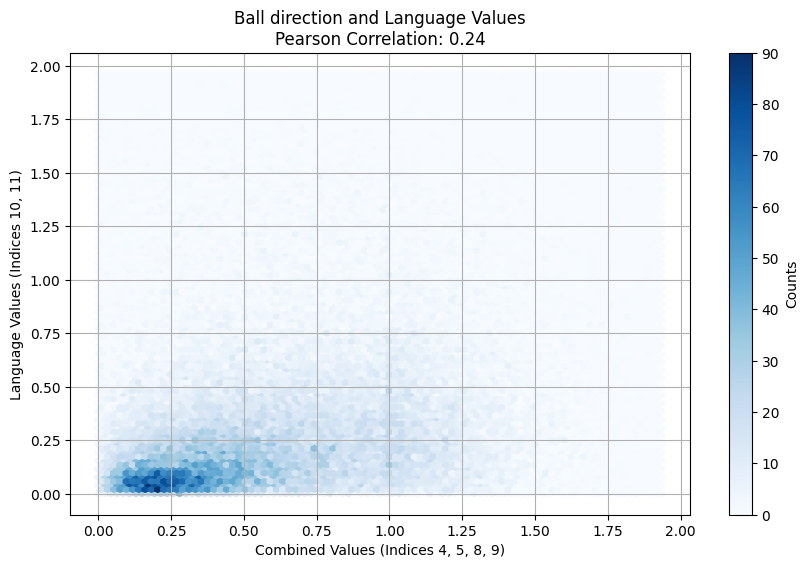

In [22]:
plt.figure(figsize=(10, 6))
plt.hexbin(combined_value, language_values, gridsize=90, cmap='Blues')
plt.colorbar(label='Counts')
plt.title(f'Ball direction and Language Values\nPearson Correlation: {correlation:.2f}')
plt.xlabel('Combined Values (Indices 4, 5, 8, 9)')
plt.ylabel('Language Values (Indices 10, 11)')
plt.grid(True)
plt.show()
